In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
!mkdir dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Get the dataset
!unzip /content/drive/MyDrive/UnetModels/classification/balanced_dataset.zip -d /content/dataset

Archive:  /content/drive/MyDrive/UnetModels/classification/balanced_dataset.zip
  inflating: /content/dataset/Normal/Normal (1868).jpg  
  inflating: /content/dataset/Normal/Normal (1044).jpg  
  inflating: /content/dataset/Normal/Normal (3183).jpg  
  inflating: /content/dataset/Normal/Normal (3120).jpg  
  inflating: /content/dataset/Normal/Normal (278).jpg  
  inflating: /content/dataset/Normal/Normal (1916).jpg  
  inflating: /content/dataset/Normal/Normal (2189).jpg  
  inflating: /content/dataset/Normal/Normal (2903).jpg  
  inflating: /content/dataset/Normal/Normal (1981).jpg  
  inflating: /content/dataset/Normal/Normal (469).jpg  
  inflating: /content/dataset/Normal/Normal (2505).jpg  
  inflating: /content/dataset/Normal/Normal (2586).jpg  
  inflating: /content/dataset/Normal/Normal (1357).jpg  
  inflating: /content/dataset/Normal/Normal (2561).jpg  
  inflating: /content/dataset/Normal/Normal (400).jpg  
  inflating: /content/dataset/Normal/Normal (197).jpg  
  inflating:

In [5]:
#Load the model here
from keras.models import load_model
model = load_model('/content/drive/MyDrive/UnetModels/pywavelettedUnet.h5')

In [6]:
!pip install pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 53.3 MB/s eta 0:00:00


Preprocessed image shape: (1, 256, 256, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


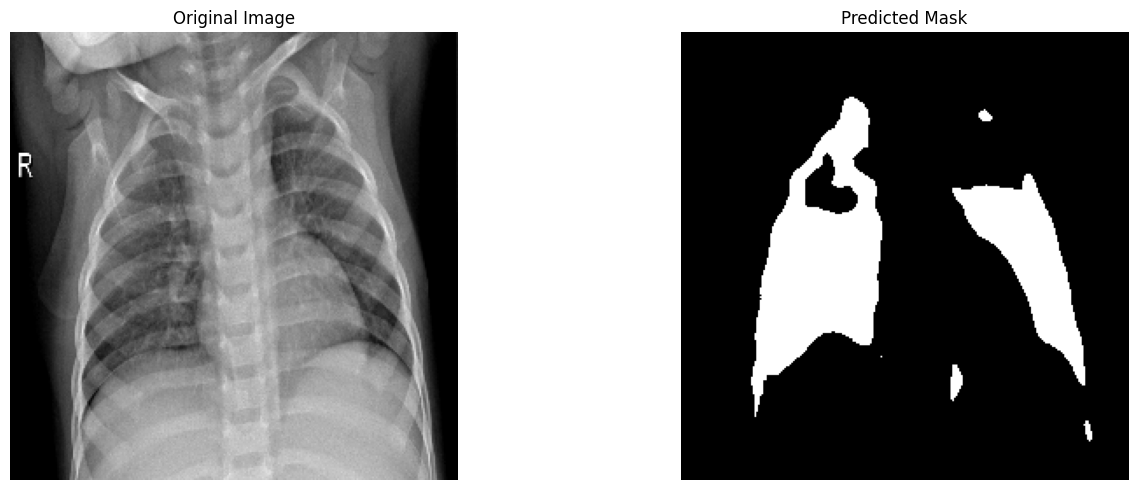

In [7]:
import pywt
def load_and_preprocess_image(image_path, wavelet='db4', image_size=(256, 256)):
    if not os.path.exists(image_path):
        raise ValueError(f"Image not found: {image_path}")

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image could not be loaded: {image_path}")

    img_resized = cv2.resize(img, image_size) / 255.0

    coeffs2 = pywt.dwt2(img_resized, wavelet)

    if coeffs2 is None or len(coeffs2) != 2:
        raise ValueError("Wavelet transformation failed to produce coefficients.")

    LL, (LH, HL, HH) = coeffs2

    LL = cv2.resize(LL, image_size)
    LH = cv2.resize(LH, image_size)
    HL = cv2.resize(HL, image_size)
    HH = cv2.resize(HH, image_size)

    wavelet_image = np.stack([LL, LH, HL, HH], axis=-1)

    return img_resized, wavelet_image


image_path = "/content/dataset/Normal/Normal (1010).jpg"
original_image, preprocessed_image = load_and_preprocess_image(image_path)

# Add a batch dimension for model prediction
preprocessed_image_batch = np.expand_dims(preprocessed_image, axis=0)

print(f"Preprocessed image shape: {preprocessed_image_batch.shape}")

# Make prediction
predicted_mask = model.predict(preprocessed_image_batch)

# Ensure the predicted mask is binary
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')


axes[1].imshow(predicted_mask_binary[0, :, :, 0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Calculate and print metrics
predicted_flat = predicted_mask_binary[0, :, :, 0].flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


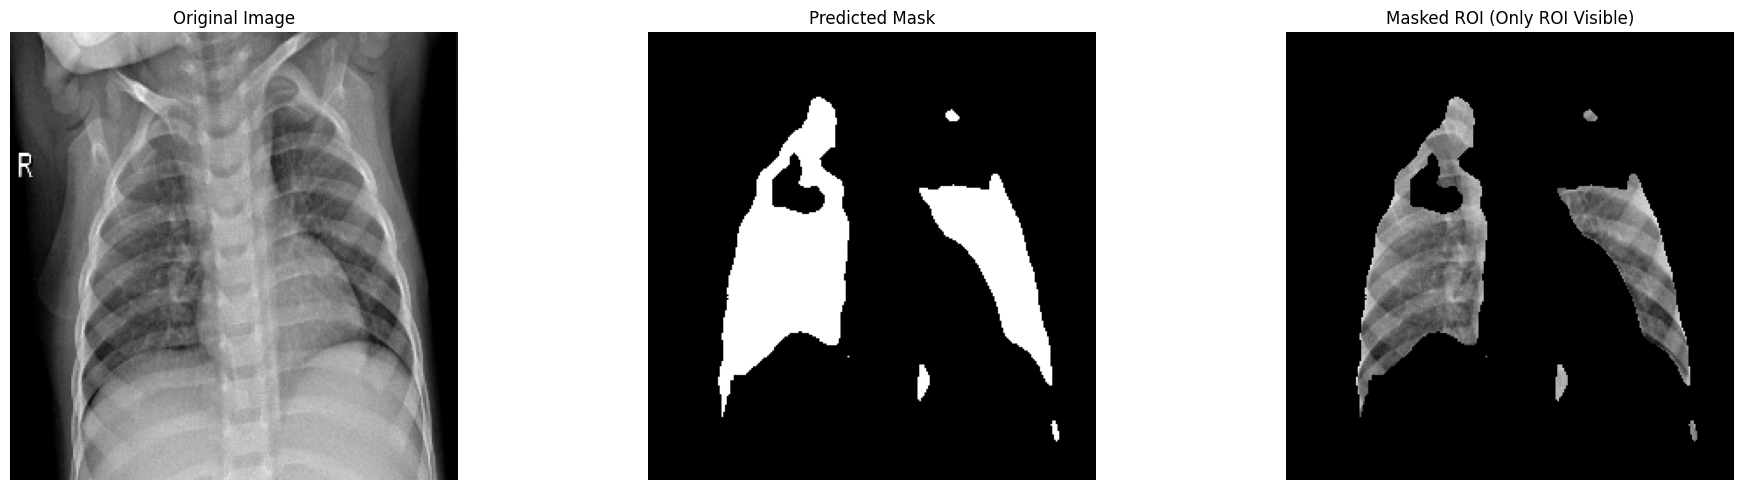

In [8]:
def load_and_preprocess_image(image_path, wavelet='db4', image_size=(256, 256)):
    if not os.path.exists(image_path):
        raise ValueError(f"Image not found: {image_path}")

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image could not be loaded: {image_path}")

    img_resized = cv2.resize(img, image_size) / 255.0

    coeffs2 = pywt.dwt2(img_resized, wavelet)
    LL, (LH, HL, HH) = coeffs2
    LL, LH, HL, HH = [cv2.resize(c, image_size) for c in [LL, LH, HL, HH]]
    wavelet_image = np.stack([LL, LH, HL, HH], axis=-1)

    return img_resized, wavelet_image


def extract_roi_mask(original_image, binary_mask):
    # Ensure binary mask is binary (0 and 1) for masking
    binary_mask = binary_mask.astype(np.uint8)

    # Mask the original image to show only the ROI
    roi_masked = original_image * binary_mask

    return roi_masked


image_path = '/content/dataset/Normal/Normal (1010).jpg'
original_image, preprocessed_image = load_and_preprocess_image(image_path)

# Prepare image for prediction
preprocessed_image_batch = np.expand_dims(preprocessed_image, axis=0)

# Make prediction and binarize mask
predicted_mask = model.predict(preprocessed_image_batch)
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Apply binary mask to original image to keep only ROI
roi_masked_image = extract_roi_mask(original_image, predicted_mask_binary[0, :, :, 0])

# Display Original Image, Predicted Mask, and Masked ROI
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(predicted_mask_binary[0, :, :, 0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

axes[2].imshow(roi_masked_image, cmap='gray')
axes[2].set_title('Masked ROI (Only ROI Visible)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

Use this function from here onwards

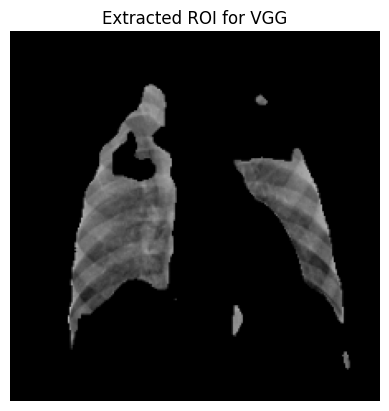

In [9]:
def extract_roi_from_mask(original_image, predicted_mask_binary):
    # Ensure the mask has been thresholded correctly
    if predicted_mask_binary.max() <= 1:
        predicted_mask_binary = predicted_mask_binary * 255

    # Resize original image to match the mask shape
    if original_image.shape != predicted_mask_binary.shape[:2]:
        original_image = cv2.resize(original_image, (predicted_mask_binary.shape[1], predicted_mask_binary.shape[0]))

    # Apply mask to the original image to get the ROI
    roi = cv2.bitwise_and(original_image, original_image, mask=predicted_mask_binary)

    # Resize ROI to VGG input size (224, 224)
    roi_resized = cv2.resize(roi, (224, 224))

    # Convert to 3 channels (VGG expects 3 channels)
    roi_resized_3ch = np.stack([roi_resized] * 3, axis=-1)

    return roi_resized_3ch

# Extract ROI
roi_image = extract_roi_from_mask(original_image, predicted_mask_binary[0, :, :, 0])
plt.imshow(roi_image, cmap='gray')
plt.title("Extracted ROI for VGG")
plt.axis('off')
plt.show()

**BUILDING THE CLASSFIER**

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

def build_vgg_classifier(input_shape=(224, 224, 3), num_classes=3):
    # Load the pre-trained VGG16 model + higher level layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of VGG16 to avoid training them
    for layer in base_model.layers:
        layer.trainable = False

    # Custom layers for our classification task
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)  # Increased to 512 for added feature capacity
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)  # Softmax for multi-class classification

    # Combine base model and custom layers
    model = Model(inputs=base_model.input, outputs=output)

    return model

# Build the model
vgg_model = build_vgg_classifier()

# Compile the model with a lower learning rate for better stability
vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Set custom learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model to confirm structure
vgg_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,561,795 (105.14 MB)

 Trainable params: 12,847,107 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

PrePare Dataset

In [15]:
import os
import numpy as np
import cv2
import pywt
import gc
from tensorflow.keras.models import load_model
import tensorflow as tf

# Load pre-trained U-Net model
# model = load_model('path_to_your_unet_model.h5')

# Define paths
input_dir = "/content/dataset"
output_dir = "/content/roi_dataset"

# Create output directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
class_dirs = ["Normal", "Pneumonia-Viral", "Pneumonia-Bacterial"]
for cls in class_dirs:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

# Function to load and preprocess the image
def load_and_preprocess_image(image_path, wavelet='db4', image_size=(256, 256)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, image_size) / 255.0
    coeffs2 = pywt.dwt2(img_resized, wavelet)
    LL, (LH, HL, HH) = coeffs2
    LL, LH, HL, HH = [cv2.resize(c, image_size) for c in [LL, LH, HL, HH]]
    wavelet_image = np.stack([LL, LH, HL, HH], axis=-1)
    return img_resized, wavelet_image

# Function to batch-process images and save segmentation masks as ROIs
def process_images_in_batches(input_class_dir, output_class_dir, model, batch_size=10):
    images = [img for img in os.listdir(input_class_dir) if os.path.isfile(os.path.join(input_class_dir, img))]
    num_batches = len(images) // batch_size + (1 if len(images) % batch_size != 0 else 0)

    for batch_num in range(num_batches):
        batch_images = images[batch_num * batch_size: (batch_num + 1) * batch_size]
        original_images = []
        preprocessed_images = []

        # Load and preprocess batch images
        for img_name in batch_images:
            img_path = os.path.join(input_class_dir, img_name)
            original_image, preprocessed_image = load_and_preprocess_image(img_path)
            original_images.append(original_image)
            preprocessed_images.append(preprocessed_image)

        # Convert batch to numpy array for prediction
        preprocessed_image_batch = np.array(preprocessed_images)

        # Predict the masks
        predicted_masks = model.predict(preprocessed_image_batch)
        predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)

        # Process each mask in the batch and save ROI
        for i, img_name in enumerate(batch_images):
            # Only process if the mask has ROI
            if np.max(predicted_masks_binary[i]) == 0:
                print(f"No ROI detected for {img_name}. Skipping...")
                continue

            # Extract ROI
            roi_image = original_images[i] * predicted_masks_binary[i, :, :, 0]
            roi_image_uint8 = (roi_image * 255).astype(np.uint8)

            # Save the ROI image
            output_path = os.path.join(output_class_dir, img_name)
            cv2.imwrite(output_path, roi_image_uint8)
            print(f"Saved ROI to: {output_path}")

        # Free memory after each batch
        del original_images, preprocessed_images, preprocessed_image_batch, predicted_masks, predicted_masks_binary
        gc.collect()

# Run the function for each class directory in small batches
for cls in class_dirs:
    input_class_dir = os.path.join(input_dir, cls)
    output_class_dir = os.path.join(output_dir, cls)
    process_images_in_batches(input_class_dir, output_class_dir, model, batch_size=10)

print("ROI extraction and saving complete!")

Streaming output truncated to the last 5000 lines.
Saved ROI to: /content/roi_dataset/Normal/Normal (400).jpg
Saved ROI to: /content/roi_dataset/Normal/Normal (1914).jpg
Saved ROI to: /content/roi_dataset/Normal/Normal (2940).jpg
Saved ROI to: /content/roi_dataset/Normal/Normal (642).jpg
Saved ROI to: /content/roi_dataset/Normal/Normal (2740).jpg
Saved ROI to: /content/roi_dataset/Normal/Normal (3220).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Saved ROI to: /content/roi_dataset/Normal/Normal (3034).jpg
Saved ROI to: /content/roi_dataset/Normal/Normal (2381).jpg
Saved ROI to: /content/roi_dataset/Normal/Normal (2733).jpg
Saved ROI to: /content/roi_dataset/Normal/Normal (3020).jpg
Saved ROI to: /content/roi_dataset/Normal/Normal (2552).jpg
Saved ROI to: /content/roi_dataset/Normal/Normal (2155).jpg
Saved ROI to: /content/roi_dataset/Normal/Normal (1916).jpg
Saved ROI to: /content/roi_dataset/Normal/Normal (1911).jpg
Saved ROI to: /content/roi_dataset/Normal/Normal (3102).jpg
Saved ROI to:

In [14]:
# import shutil

# folder_to_delete = "/content/roi_dataset"  # Replace with the actual folder name

# try:
#     shutil.rmtree(folder_to_delete)
#     print(f"Folder '{folder_to_delete}' deleted successfully.")
# except FileNotFoundError:
#     print(f"Folder '{folder_to_delete}' not found.")
# except OSError as e:
#     print(f"Error deleting folder '{folder_to_delete}': {e}")

Folder '/content/roi_dataset' deleted successfully.


In [16]:
!zip -r /content/roi_dataset.zip /content/roi_dataset
from google.colab import files
files.download("/content/roi_dataset.zip")

  adding: content/roi_dataset/ (stored 0%)
  adding: content/roi_dataset/Normal/ (stored 0%)
  adding: content/roi_dataset/Normal/Normal (2505).jpg (deflated 5%)
  adding: content/roi_dataset/Normal/Normal (2687).jpg (deflated 3%)
  adding: content/roi_dataset/Normal/Normal (2417).jpg (deflated 4%)
  adding: content/roi_dataset/Normal/Normal (296).jpg (deflated 2%)
  adding: content/roi_dataset/Normal/Normal (1280).jpg (deflated 3%)
  adding: content/roi_dataset/Normal/Normal (3109).jpg (deflated 3%)
  adding: content/roi_dataset/Normal/Normal (2442).jpg (deflated 2%)
  adding: content/roi_dataset/Normal/Normal (3246).jpg (deflated 9%)
  adding: content/roi_dataset/Normal/Normal (2588).jpg (deflated 2%)
  adding: content/roi_dataset/Normal/Normal (2758).jpg (deflated 3%)
  adding: content/roi_dataset/Normal/Normal (76).jpg (deflated 3%)
  adding: content/roi_dataset/Normal/Normal (388).jpg (deflated 3%)
  adding: content/roi_dataset/Normal/Normal (467).jpg (deflated 3%)
  adding: conte

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test Train Val Split 80 10 10

In [17]:
import os
import shutil
import random

# Define paths
roi_dir = "/content/roi_dataset"  # Original ROI dataset directory
output_base_dir = "/content/split_roi_dataset"  # Output directory for split data

# Define the split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Ensure output directories exist
splits = ['train', 'val', 'test']
class_dirs = ["Normal", "Pneumonia-Viral", "Pneumonia-Bacterial"]

for split in splits:
    for cls in class_dirs:
        os.makedirs(os.path.join(output_base_dir, split, cls), exist_ok=True)

# Split and move files
for cls in class_dirs:
    class_path = os.path.join(roi_dir, cls)
    images = os.listdir(class_path)
    random.shuffle(images)

    # Calculate split indices
    train_count = int(train_ratio * len(images))
    val_count = int(val_ratio * len(images))

    # Assign images to each set
    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Move images to respective directories
    for img_list, split in zip([train_images, val_images, test_images], splits):
        for img_name in img_list:
            src = os.path.join(class_path, img_name)
            dest = os.path.join(output_base_dir, split, cls, img_name)
            shutil.copy2(src, dest)  # Copy file to new split folder

    print(f"Completed split for class '{cls}'")

print("Dataset split complete!")

Completed split for class 'Normal'
Completed split for class 'Pneumonia-Viral'
Completed split for class 'Pneumonia-Bacterial'
Dataset split complete!


In [20]:
# prompt: code to check the number of images in a folder

import os

def count_images_in_folder(folder_path):
  """Counts the number of image files in a given folder.

  Args:
    folder_path: The path to the folder containing the images.

  Returns:
    The number of image files in the folder.
  """
  image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp')  # Add more if needed
  image_count = 0
  for filename in os.listdir(folder_path):
    if filename.lower().endswith(image_extensions):
      image_count += 1
  return image_count

folder_path = "/content/split_roi_dataset/test/Normal"  # Replace with your folder path
num_images = count_images_in_folder(folder_path)
print(f"The number of images in '{folder_path}' is: {num_images}")

folder_path = "/content/split_roi_dataset/train/Normal"  # Replace with your folder path
num_images = count_images_in_folder(folder_path)
print(f"The number of images in '{folder_path}' is: {num_images}")

folder_path = "/content/split_roi_dataset/val/Normal"  # Replace with your folder path
num_images = count_images_in_folder(folder_path)
print(f"The number of images in '{folder_path}' is: {num_images}")

folder_path = "/content/roi_dataset/Normal"  # Replace with your folder path
num_images = count_images_in_folder(folder_path)
print(f"The number of images in '{folder_path}' is: {num_images}")

The number of images in '/content/split_roi_dataset/test/Normal' is: 167
The number of images in '/content/split_roi_dataset/train/Normal' is: 1324
The number of images in '/content/split_roi_dataset/val/Normal' is: 165
The number of images in '/content/roi_dataset/Normal' is: 1656


In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Paths for train, validation, and test sets
train_dir = "/content/split_roi_dataset/train"
val_dir = "/content/split_roi_dataset/val"
test_dir = "/content/split_roi_dataset/test"

# Image Data Generators for training, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3971 images belonging to 3 classes.
Found 495 images belonging to 3 classes.
Found 499 images belonging to 3 classes.


In [26]:
# Train the model
epochs = 30
history = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=epochs
)

Epoch 1/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 52s 399ms/step - accuracy: 0.6584 - loss: 0.6916 - val_accuracy: 0.6646 - val_loss: 0.6894
Epoch 2/30
  1/124 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - accuracy: 0.6562 - loss: 0.7920

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6562 - loss: 0.7920 - val_accuracy: 0.6000 - val_loss: 0.7091
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 80s 392ms/step - accuracy: 0.6683 - loss: 0.7134 - val_accuracy: 0.6687 - val_loss: 0.6744
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.7500 - loss: 0.5891 - val_accuracy: 0.8000 - val_loss: 0.6690
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 81s 392ms/step - accuracy: 0.6630 - loss: 0.6962 - val_accuracy: 0.6896 - val_loss: 0.6504
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7188 - loss: 0.6576 - val_accuracy: 0.6000 - val_loss: 0.6402
Epoch 7/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 82s 401ms/step - accuracy: 0.6831 - loss: 0.6822 - val_accuracy: 0.6521 - val_loss: 0.6859
Epoch 8/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6562 - loss: 0.7822 - val_accuracy: 0.6000 - val_loss: 0.6607
Epoch 9/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 81s 399ms/step - accuracy: 0.6772 - loss: 0.6718 - val_accuracy:

In [29]:
test_loss, test_acc = vgg_model.evaluate(test_generator, steps=test_generator.samples)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.7216 - loss: 0.6008  
Test Accuracy: 72.14%


In [ ]:
#use Early stopping later on
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',      # Metric to monitor
    patience=5,              # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # Verbosity mode
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

MobileNet Classification

In [31]:
from keras import backend as K
K.clear_session()

In [36]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

def build_mobilenet_classifier(input_shape=(224, 224, 3), num_classes=3):
    # Load the pre-trained MobileNet model
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of MobileNet
    for layer in base_model.layers:
        layer.trainable = False

    # Custom layers for our classification task
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)  # Softmax for multi-class classification

    # Combine base model and custom layers
    model = Model(inputs=base_model.input, outputs=output)

    return model

# Build the model
mobilenet_model = build_mobilenet_classifier()

# Compile the model with relevant metrics
mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Image data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3971 images belonging to 3 classes.
Found 495 images belonging to 3 classes.
Found 499 images belonging to 3 classes.


In [38]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
mobilenet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.6099 - loss: 0.7708 - val_accuracy: 0.6646 - val_loss: 0.6636
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.5312 - loss: 0.8324 - val_accuracy: 0.4667 - val_loss: 0.8341
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.6319 - loss: 0.7218 - val_accuracy: 0.6875 - val_loss: 0.6756
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5312 - loss: 0.8457 - val_accuracy: 0.6667 - val_loss: 0.7567
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.6607 - loss: 0.6325 - val_accuracy: 0.7000 - val_loss: 0.6435
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5625 - loss: 0.7410 - val_accuracy: 0.6000 - val_loss: 0.6092
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.6529 - loss: 0.6872 - val_accuracy: 0.7146 - val_loss: 0.6140
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7188 - loss: 0.5387 - val_acc

In [39]:
test_loss, test_acc = mobilenet_model.evaluate(test_generator, steps=test_generator.samples)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

  3/499 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.7882 - loss: 0.4715

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7363 - loss: 0.5561   
Test Accuracy: 73.55%


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


ResNet Classification:

In [40]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

def build_resnet_classifier(input_shape=(224, 224, 3), num_classes=3):
    # Load the pre-trained ResNet50 model + higher level layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of ResNet50 to avoid training them
    for layer in base_model.layers:
        layer.trainable = False

    # Custom layers for our classification task
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)  # Softmax for multi-class classification

    # Combine base model and custom layers
    model = Model(inputs=base_model.input, outputs=output)

    return model

# Build the model
resnet_model = build_resnet_classifier()

# Compile the model with relevant metrics
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 49,278,851 (187.98 MB)

 Trainable params: 25,691,139 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set up callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('resnet_model.keras', save_best_only=True)
]

# Train the model
history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 283ms/step - accuracy: 0.3229 - loss: 4.5669 - val_accuracy: 0.5657 - val_loss: 1.0720
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.4149 - loss: 1.0567 - val_accuracy: 0.5677 - val_loss: 0.9769
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.4628 - loss: 1.0204 - val_accuracy: 0.5232 - val_loss: 1.0191
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 175ms/step - accuracy: 0.4474 - loss: 1.0213 - val_accuracy: 0.5879 - val_loss: 0.9592
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.4681 - loss: 1.0018 - val_accuracy: 0.5737 - val_loss: 0.8989
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.4707 - loss: 0.9960 - val_accuracy: 0.5697 - val_loss: 0.9697
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.4724 - loss: 0.9948 - val_accuracy: 0.5434 - val_loss: 0.9079
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - accuracy: 0.4463 - loss: 1

In [43]:
test_loss, test_acc = resnet_model.evaluate(test_generator, steps=test_generator.samples)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

499/499 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6673 - loss: 0.8308    
Test Accuracy: 66.73%


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


EffecientNet Classifer

In [44]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build the EfficientNet model
def build_efficientnet_classifier(input_shape=(224, 224, 3), num_classes=3):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

# Build and compile the model
efficientnet_model = build_efficientnet_classifier()
efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [45]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('efficientnet_model.keras', save_best_only=True)
]

history = efficientnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 320ms/step - accuracy: 0.3298 - loss: 4.7581 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.3409 - loss: 1.1107 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.3201 - loss: 1.1035 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.3395 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.3228 - loss: 1.0993 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.3334 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.3456 - loss: 1.0985 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.3320 - loss: 1.1209 - val

In [46]:
test_loss, test_acc = efficientnet_model.evaluate(test_generator, steps=test_generator.samples)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7356 - loss: 0.5570  
Test Accuracy: 73.55%


Xception Classifer

In [47]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build the Xception model
def build_xception_classifier(input_shape=(224, 224, 3), num_classes=3):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

# Build and compile the model
xception_model = build_xception_classifier()
xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('xception_model.keras', save_best_only=True)
]

# Train the model
history = xception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 488ms/step - accuracy: 0.4910 - loss: 12.5976 - val_accuracy: 0.5919 - val_loss: 0.7501
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 54s 427ms/step - accuracy: 0.5946 - loss: 0.8002 - val_accuracy: 0.6788 - val_loss: 0.7097
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 137ms/step - accuracy: 0.5800 - loss: 0.7791 - val_accuracy: 0.6808 - val_loss: 0.7381
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 396ms/step - accuracy: 0.6196 - loss: 0.7360 - val_accuracy: 0.6768 - val_loss: 0.7057
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 425ms/step - accuracy: 0.6490 - loss: 0.7326 - val_accuracy: 0.6788 - val_loss: 0.6586
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - accuracy: 0.6317 - loss: 0.7190 - val_accuracy: 0.6768 - val_loss: 0.6859
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.6544 - loss: 0.6962 - val_accuracy: 0.6525 - val_loss: 0.7236
Epoch 8/50
125/125 ━━━━━━━━━━━━

In [48]:
test_loss, test_acc = xception_model.evaluate(test_generator, steps=test_generator.samples)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

499/499 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7499 - loss: 0.5723   
Test Accuracy: 74.95%


Testing an Image

In [55]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import pywt

# Load U-Net model for ROI extraction and the disease classification model
unet_model = model

# Function to preprocess and get the ROI using the U-Net
def get_roi(image_path):
    # Load image and preprocess
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (256, 256)) / 255.0
    input_img = np.expand_dims(np.stack([img_resized]*4, axis=-1), axis=0)  # Adjust if necessary for your U-Net input shape

    # Predict mask with U-Net
    predicted_mask = unet_model.predict(input_img)[0, :, :, 0]
    predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

    # Extract ROI
    roi = cv2.bitwise_and(img_resized, img_resized, mask=predicted_mask_binary)
    return cv2.resize(roi, (224, 224))  # Resize for classification model

# Function to classify the ROI
def predict_disease(image_path):
    roi = get_roi(image_path)
    roi_expanded = np.expand_dims(np.stack([roi]*3, axis=-1), axis=0)  # Make it 3-channel for VGG/ResNet/MobileNet input

    # Get prediction from classification model
    prediction = mobilenet_model.predict(roi_expanded)
    class_index = np.argmax(prediction)
    classes = ["Normal", "Pneumonia-Viral", "Pneumonia-Bacterial"]  # Modify if your labels are different
    predicted_class = classes[class_index]

    print(f"Predicted Disease: {predicted_class} (Confidence: {prediction[0][class_index]:.2f})")
    return predicted_class, prediction[0][class_index]

# Usage example
image_path = '/content/dataset/Normal/Normal (1).jpg'
predicted_class, confidence = predict_disease(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Disease: Pneumonia-Viral (Confidence: 0.49)


In [61]:
import os
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your U-Net model and classification model (e.g., MobileNet)
unet_model = model  # Ensure this is your trained U-Net model
classification_model = mobilenet_model  # Change as needed

# Function to load and preprocess the image with wavelet transform
def load_and_preprocess_image(image_path, wavelet='db4', image_size=(256, 256)):
    if not os.path.exists(image_path):
        raise ValueError(f"Image not found: {image_path}")

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image could not be loaded: {image_path}")

    img_resized = cv2.resize(img, image_size) / 255.0

    coeffs2 = pywt.dwt2(img_resized, wavelet)
    LL, (LH, HL, HH) = coeffs2
    LL, LH, HL, HH = [cv2.resize(c, image_size) for c in [LL, LH, HL, HH]]
    wavelet_image = np.stack([LL, LH, HL, HH], axis=-1)

    return img_resized, wavelet_image

# Function to extract the ROI using the U-Net model
def extract_roi(original_image, model):
    # Ensure the image has the correct shape (1, height, width, channels)
    preprocessed_image_batch = np.expand_dims(original_image, axis=0)  # Add batch dimension

    # Make prediction and binarize mask
    predicted_mask = model.predict(preprocessed_image_batch)
    predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

    # Extract ROI
    roi_masked = original_image * predicted_mask_binary[0, :, :, 0]  # Use first image in batch
    return roi_masked, predicted_mask_binary[0, :, :, 0]  # Return both masked ROI and the mask

# Function to classify the extracted ROI
def classify_disease(roi, classification_model):
    roi_resized = cv2.resize(roi, (224, 224))  # Resize for classification model
    roi_expanded = np.expand_dims(roi_resized, axis=0)  # Add batch dimension
    roi_expanded = np.repeat(roi_expanded[..., np.newaxis], 3, axis=-1)  # Convert to 3-channel if necessary

    # Get prediction from classification model
    prediction = classification_model.predict(roi_expanded)
    class_index = np.argmax(prediction)
    classes = ["Normal", "Pneumonia-Viral", "Pneumonia-Bacterial"]  # Adjust as needed
    predicted_class = classes[class_index]

    return predicted_class, prediction[0][class_index]

# Main function to predict disease from an image
def predict_disease(image_path):
    original_image, _ = load_and_preprocess_image(image_path)

    # Extract ROI
    roi, mask = extract_roi(original_image, unet_model)

    # Classify the extracted ROI
    predicted_class, confidence = classify_disease(roi, classification_model)

    # Display images
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')

    axes[2].imshow(roi, cmap='gray')
    axes[2].set_title('Masked ROI')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Predicted Disease: {predicted_class} (Confidence: {confidence:.2f})")
    return predicted_class, confidence

# Usage example
image_path = '/content/dataset/Normal/Normal (1010).jpg'  # Change to your test image path
predicted_class, confidence = predict_disease(image_path)

ValueError: as_list() is not defined on an unknown TensorShape.